In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

os.makedirs('utils/', exist_ok=True)
os.chdir('utils')

! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/utils.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/attention_modules.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/backbones.py

os.chdir('/content')
print("Current working directory", os.getcwd())

Current working directory /content


In [4]:
from utils import vision
from utils import utils
from utils import losses
from utils import models
from utils import backbones
from utils.attention_modules import Conv2DLayerBN, Conv2DLayerRes, ChannelGate, SpatialGate, CBAM

### Experiment Setup Start

In [5]:
# Create experiment folder
EXPERIMENT_NAME = 'ConvAE_Model'
EXPERIMENT_SAVE_DIR = os.path.join('/content/drive/MyDrive/MASTER/Master_Thesis/Experiments', EXPERIMENT_NAME)

In [6]:
experiment = {
    'TYPE': 'test',        # Experiment type: 'train', 'test'
    'ACCELERATOR': 'GPU',   # 'CPU', 'GPU' or 'TPU'

    # Input data
    'DATASET': 'BD67_Dataset',
    'IMAGE_SIZE': (256, 256),
    'INPUT_SHAPE': (256, 256, 3),
    'PATCH_SIZE': 256,
    'VALID_SIZE': 0.1,      # Validation data size: (Valid Data) / (All Data)
    'DATA_AUG': True,       # Apply data augmentation
    'DATA_AUG_POWER': 2,    # Data augmentation power: How many times data
     # augmentation will be applied to the whole dataset. default 1

    # Model
    'BACKBONE': 'custom',      # 'custom', 'VGG16', 'VGG19', 'ResNet50' - default 'custom'
    'LAST_TRANIABLE_LAYERS': 5,  # number of last trainable layers of pre-trained backbone models, fine-tuning
    'BATCH_SIZE': 16,            # IF TPU is active set 4, otherwise set anything
    'EPOCHS': 200,
    'OPTIMIZER': 'Adam',  # TODO: Try 'rmsprop' optimizer
    'LEARNING_RATE': 1e-4,
    # set latent dim - shape: (LATENT_DIM, 1) - default 200
    'LATENT_DIM': 250,

    # Loss
    'RECONS_LOSS': 'MSE',  # Reconstruction loss ('SSIM', 'MSE', 'MAE', 'PERCEPTUAL')
    'PERCEPTUAL_LAYERS': [35,77,139,150],    # 'conv2_block3_3_conv', 'conv3_block4_3_conv', 'conv4_block6_3_conv', 'conv5_block1_3_conv'
    'PERCEP_LOSS_MODEL': 'ResNet50', # 'custom', 'VGG16', 'VGG19', 'ResNet50' - default 'VGG16'
    'PERP_LOSS_LAMBDA': 1,    # Perceptual loss coeff
    'MSE_LOSS_LAMBDA': 0.5,     # MSE coeff
    'LRELU_SLOPE': 0.2,       # Leaky ReLU activation function slope value

    # Save model
    'SAVE_WEIGHTS_PER_EPOCH': 50,  # Checkpoints
}

In [7]:
if experiment['TYPE'] == 'train':
    assert(EXPERIMENT_NAME != '...')
    # Create experiment folder
    os.makedirs(EXPERIMENT_SAVE_DIR, exist_ok=True)

    # Model checkpoints will be save in exp_save_dir
    exp_save_dir = utils.create_experimental_output(experiment, EXPERIMENT_SAVE_DIR)

    TRAINING_WEIGHT_DIR = os.path.join(exp_save_dir, 'training_weights')
    # Create folder for checkpoints (training weights)
    os.makedirs(TRAINING_WEIGHT_DIR, exist_ok=True)
else:  # test mode
    # Set experiment save directory and training weight directory manually
    exp_save_dir = '/content/drive/MyDrive/MASTER/Master_Thesis/Experiments/ConvAE_Model/experiment_3'
    TRAINING_WEIGHT_DIR = os.path.join(exp_save_dir, 'training_weights')

In [8]:
print(f"...Experiment {exp_save_dir.split('experiment_')[1]} was initialized...")
print(f"Experiment directory: {EXPERIMENT_SAVE_DIR}")
print(f"Training weights save directory: {TRAINING_WEIGHT_DIR}")

...Experiment 3 was initialized...
Experiment directory: /content/drive/MyDrive/MASTER/Master_Thesis/Experiments/ConvAE_Model
Training weights save directory: /content/drive/MyDrive/MASTER/Master_Thesis/Experiments/ConvAE_Model/experiment_3/training_weights


### Experiment Setup End

In [9]:
ROOT_PATH = '/content'
DATASET_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset'
TFRECORD_TRAIN_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_TFRecord/images.tfrecords'
TFRECORD_TEST_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_TFRecord/images_test.tfrecords'
BD67_NORMAL_PATH = os.path.join(DATASET_PATH, 'defect_free')
BD67_NORMAL_FRONT_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/partitioned/grid_0')
BD67_NORMAL_FRONT_ROTATED_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/rotated_images/partitioned/grid_0')
BD67_NORMAL_REAR_PATH = os.path.join(DATASET_PATH, 'defect_free/Rear')
BD67_DEFECTED_FRONT_PATH = os.path.join(DATASET_PATH, 'defected/Front/partitioned/grid_0')
BD67_DEFECTED_REAR_PATH = os.path.join(DATASET_PATH, 'defected/Rear')
REFERENCE_BD67_NORMAL_FRONT = os.path.join(DATASET_PATH, 'defect_free/Front/reference_img')

In [10]:
img_files = utils.get_image_file_list("/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset/defect_free/Front/cropped", 'png')
rotated_img_files = utils.get_image_file_list("/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset/defect_free/Front/rotated_images/cropped", 'png')
all_img_files = img_files + rotated_img_files
test_img_files = utils.get_image_file_list("/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset/defected/Front/cropped", 'png')

print("Number of flat image files: ", len(img_files))
print("Number of rotated image files: ", len(rotated_img_files))
print("Number of all image files: ", len(all_img_files))

Number of flat image files:  110
Number of rotated image files:  105
Number of all image files:  215


In [11]:
all_img_files = img_files

In [12]:
test_img = utils.load_images(all_img_files[0], scl=True)

grid_width = test_img.shape[1] // experiment['PATCH_SIZE']
grid_height = test_img.shape[0] // experiment['PATCH_SIZE']

In [13]:
all_imgs = utils.patchify_images(all_img_files, patch_size=experiment['PATCH_SIZE'])
all_imgs = utils.cvt_color_BGR2RGB(all_imgs)

['absl-py', 'aiohttp', 'aiosignal', 'alabaster', 'albumentations', 'altair', 'anyio', 'appdirs', 'argon2-cffi', 'argon2-cffi-bindings', 'array-record', 'arviz', 'astropy', 'astunparse', 'async-timeout', 'atpublic', 'attrs', 'audioread', 'autograd', 'Babel', 'backcall', 'beautifulsoup4', 'bidict', 'bigframes', 'bleach', 'blinker', 'blis', 'blosc2', 'bokeh', 'bqplot', 'branca', 'build', 'CacheControl', 'cachetools', 'catalogue', 'certifi', 'cffi', 'chardet', 'charset-normalizer', 'chex', 'click', 'click-plugins', 'cligj', 'cloudpickle', 'cmake', 'cmdstanpy', 'colorcet', 'colorlover', 'colour', 'community', 'confection', 'cons', 'contextlib2', 'contourpy', 'cryptography', 'cufflinks', 'cupy-cuda12x', 'cvxopt', 'cvxpy', 'cycler', 'cymem', 'Cython', 'dask', 'datascience', 'db-dtypes', 'dbus-python', 'debugpy', 'decorator', 'defusedxml', 'diskcache', 'distributed', 'distro', 'dlib', 'dm-tree', 'docutils', 'dopamine-rl', 'duckdb', 'earthengine-api', 'easydict', 'ecos', 'editdistance', 'eerepr

(-0.5, 1791.5, 1279.5, -0.5)

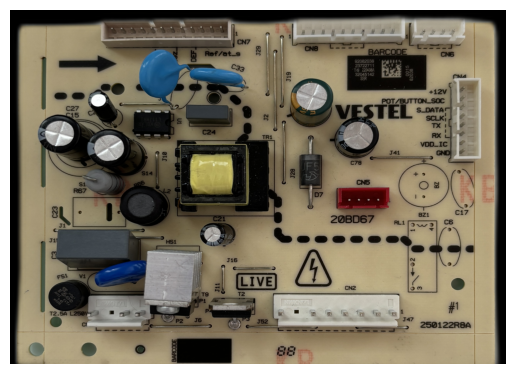

In [14]:
res = utils.unpatchify_img(all_imgs[:(grid_width*grid_height)], grid=(grid_width,grid_height))
plt.imshow(res)
plt.axis('off')

In [15]:
import random as rnd

def create_dataset_pipeline(partitioned_dataset, grid_num):
    images = []
    labels = []
    grid_id = 0

    for img_id, image in enumerate(partitioned_dataset):
        images.append(image)
        labels.append(grid_id)
        grid_id += 1
        if grid_id >= grid_num:
            grid_id = 0

    indices = list(range(len(images)))
    rnd.shuffle(indices)

    shuffled_images = [images[i] for i in indices]
    shuffled_labels = [labels[i] for i in indices]

    X_train, y_train = np.array(shuffled_images), np.array(shuffled_labels)

    return X_train, y_train

In [16]:
X_train, y_train = create_dataset_pipeline(partitioned_dataset=all_imgs, grid_num=grid_width*grid_height)
del all_imgs

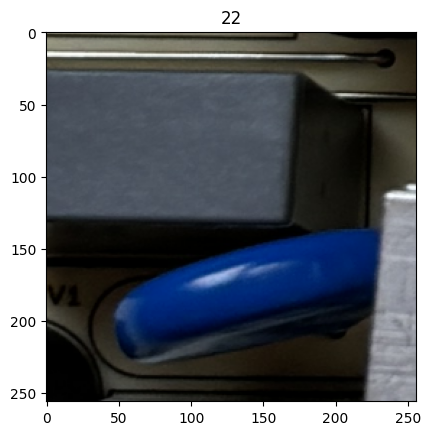

In [17]:
id = 4

plt.imshow(X_train[id])
plt.title(y_train[id])
plt.show()

Data Augmentation Layer

In [18]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

if experiment['DATA_AUG']:
    # Setup data augmentation
    data_aug_layer = Sequential([
      #preprocessing.RandomFlip("horizontal_and_vertical"), # randomly flip images on horizontal/vertical edge
      #preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
      #preprocessing.RandomZoom(0.2), # randomly zoom into an image
      tf.keras.layers.RandomBrightness(factor=0.2, value_range=[0.0, 1.0], seed=None),
      # value_range parameter should be [0.0, 1.0] for RandomBrightness
      # if images were scaled before, default value is [0,255]
      tf.keras.layers.RandomContrast(0.2, seed=None),
      #tf.keras.layers.RandomCrop(256, 256, seed=None), Error - Image size changes
      #preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
      #preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
      #preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
    ], name="data_aug_layer")
else:
    data_aug_layer = None

In [19]:
def apply_data_augmentation(images, data_aug_layer, factor=1):
    temp_images = images

    def data_aug(image):
        image = data_aug_layer(image)
        return tf.clip_by_value(image, 0.0, 1.0)

    for _ in range(factor):
        aug_images = data_aug(temp_images)
        images = np.concatenate((images, aug_images.numpy()), axis=0)

    return images

In [20]:
# Memory overflow Problem
#X_train = apply_data_augmentation(X_train, data_aug_layer,
#                                  factor=experiment['DATA_AUG_POWER'])
#np.random.shuffle(X_train)

Apply same process to the test dataset

In [21]:
test_imgs = utils.patchify_images(test_img_files, patch_size=experiment['PATCH_SIZE'])
test_imgs = utils.cvt_color_BGR2RGB(test_imgs)
X_test, y_test = create_dataset_pipeline(partitioned_dataset=test_imgs, grid_num=grid_width*grid_height)
del test_imgs

In [22]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [23]:
def show_sample_images_from_dataset(images, labels):
    fig = plt.figure(figsize=(10, 10))

    for index, image in enumerate(images):  # Get first batch
      plt.subplot(4, 4, index + 1)
      plt.imshow(image[:, :, :])
      plt.title(f"Label: {labels[index]}")
      plt.axis('off')
      if index >= ((4*4)-1):
        break

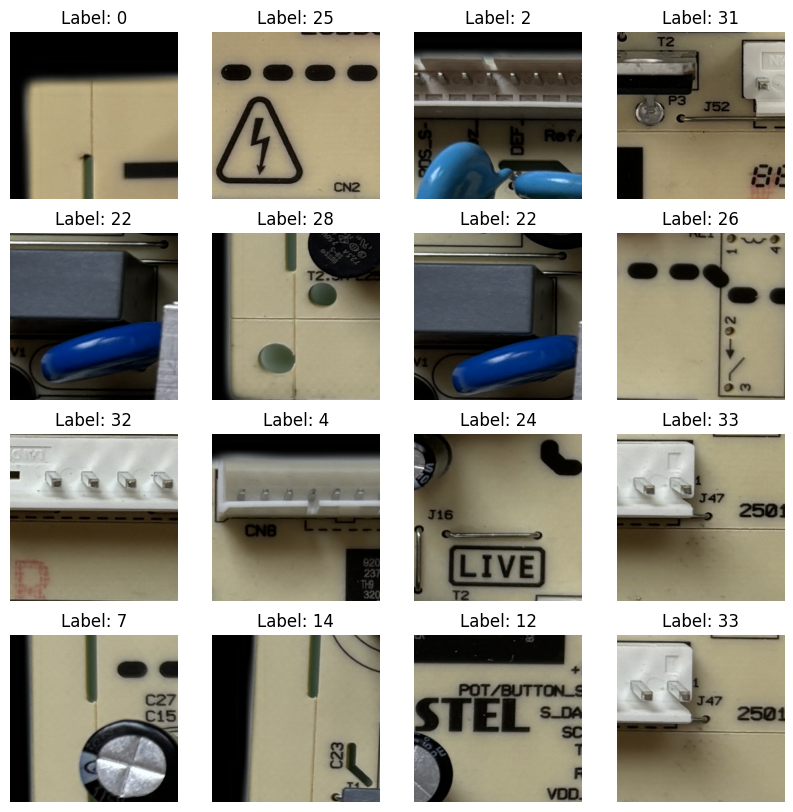

In [24]:
show_sample_images_from_dataset(X_train, np.argmax(y_train, axis=1))

In [25]:
def create_vgg16_base_model(input_shape, output_size, first_trainable_layer_ix=None, verbose=0):
    vgg16_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape= input_shape)

    #input = tf.keras.Input(shape=(256, 256, 3))
    #input = data_aug_layer(input)

    trainable = False
    for layer_ix in range(len(vgg16_model.layers)):
        if layer_ix == first_trainable_layer_ix:
            trainable = True   # Set layers as trainable after first_trainable_layer
            if verbose > 0:
                print(f"{layer_ix}. '{vgg16_model.get_layer(index=layer_ix).name}' layer is the first trainable layer.")
        if layer_ix == 17:  # block5_conv3
            last_conv_layer_out = (vgg16_model.get_layer(index=layer_ix).output)
            if verbose > 0:
                print(f"{layer_ix}. '{vgg16_model.get_layer(index=layer_ix).name}' layer is the last convolutional layer to extract gradients.\n")
        vgg16_model.get_layer(index=layer_ix).trainable = trainable

    x = vgg16_model.output # vgg16_model(input)
    x = tf.keras.layers.GlobalAveragePooling2D()(x) # Use GlobalAveragePooling and NOT flatten.
    x = tf.keras.layers.Dense(output_size, activation="softmax")(x)  # We are defining this as multiclass problem.

    #return Model(input, [last_conv_layer_out, x])
    #return Model(vgg16_model.input, [last_conv_layer_out, x])
    return Model(vgg16_model.input, x)

In [26]:
vgg16_model = create_vgg16_base_model(input_shape=experiment['INPUT_SHAPE'],
                                      output_size=grid_width*grid_height,
                                      first_trainable_layer_ix=14,  # block4_pool
                                      verbose=1)
print(vgg16_model.summary())

58889256/58889256 [==============================] - 2s 0us/step
14. 'block4_pool' layer is the first trainable layer.
17. 'block5_conv3' layer is the last convolutional layer to extract gradients.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                            

In [27]:
#for ix, layer in enumerate(vgg16_model.layers):
#    print(f"{ix}. {layer.name}: {layer.trainable}")

In [28]:
vgg16_model.compile(loss = "categorical_crossentropy",
                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [31]:
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (3850, 256, 256, 3)
X_test.shape: (350, 256, 256, 3)
y_train.shape: (3850, 35)
y_test.shape: (350, 35)


In [30]:
vgg16_model_hist = vgg16_model.fit(X_train, y_train, batch_size=experiment['BATCH_SIZE'],
                                   epochs=experiment['EPOCHS'], verbose = 1,
                                   validation_data=(X_test, y_test))

Epoch 1/200
241/241 [==============================] - 49s 149ms/step - loss: 0.2954 - accuracy: 0.9413 - val_loss: 0.0784 - val_accuracy: 0.9800
Epoch 2/200
241/241 [==============================] - 23s 95ms/step - loss: 5.6823e-05 - accuracy: 1.0000 - val_loss: 0.0777 - val_accuracy: 0.9800
Epoch 3/200
241/241 [==============================] - 24s 100ms/step - loss: 2.5083e-05 - accuracy: 1.0000 - val_loss: 0.0677 - val_accuracy: 0.9800
Epoch 4/200
241/241 [==============================] - 24s 101ms/step - loss: 1.4272e-05 - accuracy: 1.0000 - val_loss: 0.0587 - val_accuracy: 0.9857
Epoch 5/200
241/241 [==============================] - 24s 101ms/step - loss: 9.0096e-06 - accuracy: 1.0000 - val_loss: 0.0549 - val_accuracy: 0.9857
Epoch 6/200
241/241 [==============================] - 24s 101ms/step - loss: 5.9843e-06 - accuracy: 1.0000 - val_loss: 0.0452 - val_accuracy: 0.9857
Epoch 7/200
 23/241 [=>............................] - ETA: 19s - loss: 6.5368e-06 - accuracy: 1.0000

KeyboardInterrupt: ignored

In [32]:
#vision.plot_loss_curves(vgg16_model_hist, all_in_one=False)

NameError: ignored

In [33]:
loss, acc = vgg16_model.evaluate(X_test, y_test)

print("Accuracy = ", (acc * 100.0), "%")

11/11 [==============================] - 15s 807ms/step - loss: 0.0553 - accuracy: 0.9800
Accuracy =  98.00000190734863 %


1/1 [==============================] - 2s 2s/step
The prediction result for 1.test image : 22 - 22


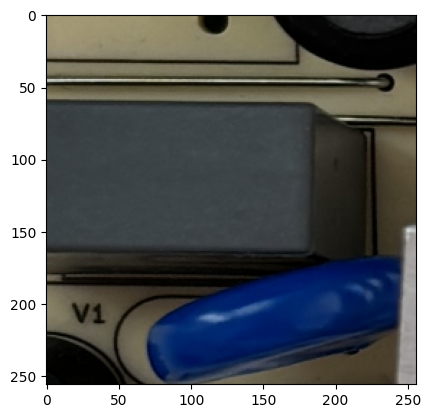

In [34]:
ix = 1
plt.imshow(X_test[ix])

input_img = np.expand_dims(X_test[ix], axis=0)

print(f"The prediction result for {ix}.test image : {np.argmax(vgg16_model.predict(input_img))} - {np.argmax(y_test[ix])}", )

In [36]:
y_pred = np.argmax(vgg16_model.predict(X_test), axis=1)

11/11 [==============================] - 1s 145ms/step


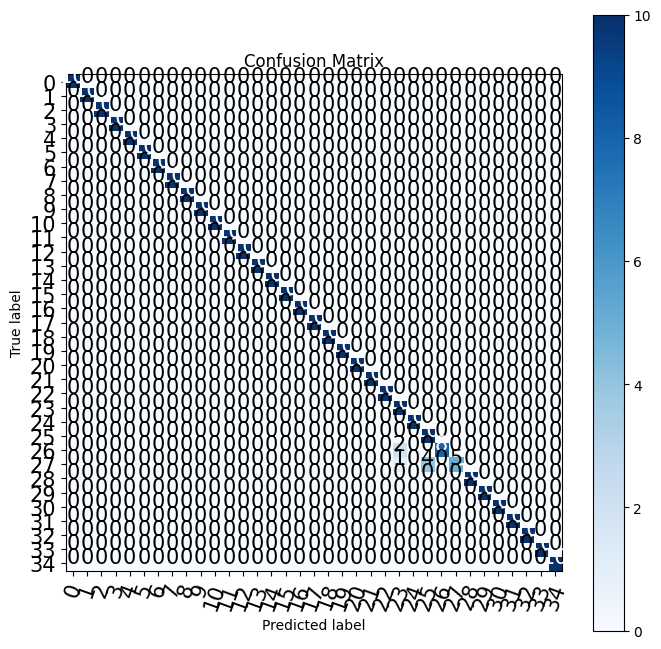

In [37]:
vision.show_confusion_matrix(np.argmax(y_test, axis=1), y_pred, figsize=(8,8))

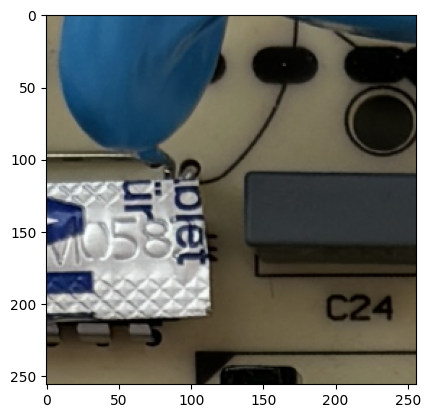

In [48]:
defected_image_idx = np.where(y_pred == 9)[0]

defected = [X_test[ix] for ix in defected_image_idx]

plt.imshow(defected[1])

1/1 [==============================] - 0s 19ms/step


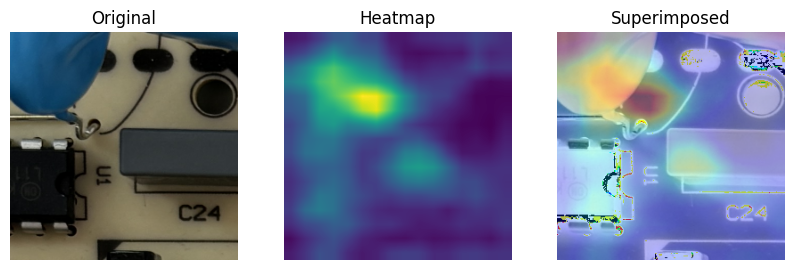

In [61]:
ix = 0

gradCAM = vision.GradCAM(vgg16_model, "block5_conv3")
class_id = np.argmax(vgg16_model.predict(np.expand_dims(defected[ix], axis=0))[0])

(heatmap, output) = gradCAM(np.expand_dims(defected[ix], axis=0), defected[ix]*255, class_id, alpha=0.4)

fig = plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(defected[ix])
plt.title("Original")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(heatmap)
plt.title("Heatmap")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(output)
plt.title("Superimposed")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 20ms/step


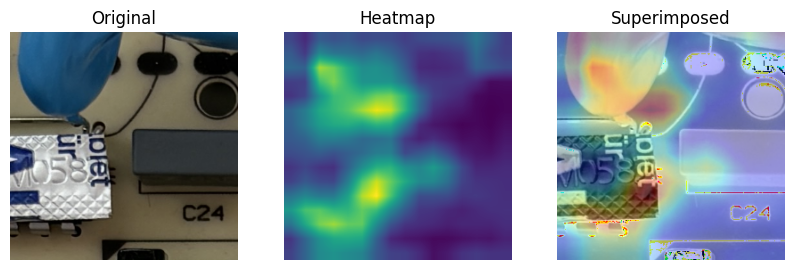

In [62]:
ix = 1

class_id_2 = np.argmax(vgg16_model.predict(np.expand_dims(defected[ix], axis=0))[0])

(heatmap2, output2) = gradCAM(np.expand_dims(defected[ix], axis=0), defected[ix]*255, class_id, alpha=0.4)

fig = plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(defected[ix])
plt.title("Original")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(heatmap2)
plt.title("Heatmap")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(output2)
plt.title("Superimposed")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 24ms/step


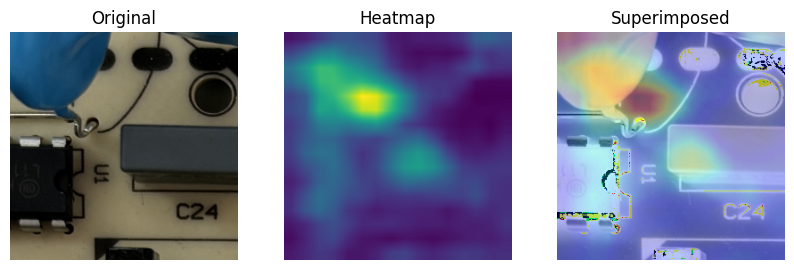

In [63]:
ix = 2

class_id = np.argmax(vgg16_model.predict(np.expand_dims(defected[ix], axis=0))[0])

(heatmap3, output3) = gradCAM(np.expand_dims(defected[ix], axis=0), defected[ix]*255, class_id, alpha=0.4)

fig = plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(defected[ix])
plt.title("Original")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(heatmap3)
plt.title("Heatmap")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(output3)
plt.title("Superimposed")
plt.axis('off')
plt.show()

In [83]:
heatmap_diff = np.abs((heatmap / 255.0) - (heatmap2 / 255.0))

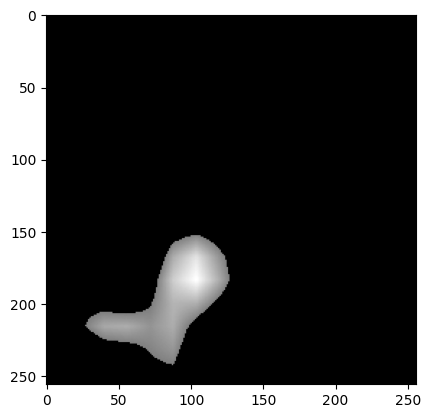

In [94]:
THRESHOLD = 0.5

heatmap_diff_show = heatmap_diff.copy()

numer = heatmap_diff_show - np.min(heatmap_diff_show)
denom = (heatmap_diff_show.max() - heatmap_diff_show.min()) + 1e-8
heatmap_diff_show = numer / denom

heatmap_diff_show[heatmap_diff_show < THRESHOLD] = 0.0
plt.imshow(heatmap_diff_show, cmap='gray')

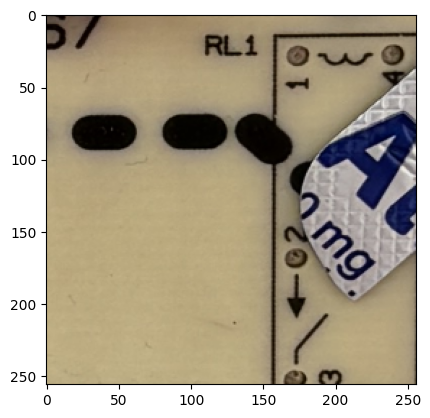

In [99]:
defected_image_idx = np.where(y_pred == 26)[0]

defected = [X_test[ix] for ix in defected_image_idx]

plt.imshow(defected[2])

1/1 [==============================] - 0s 28ms/step


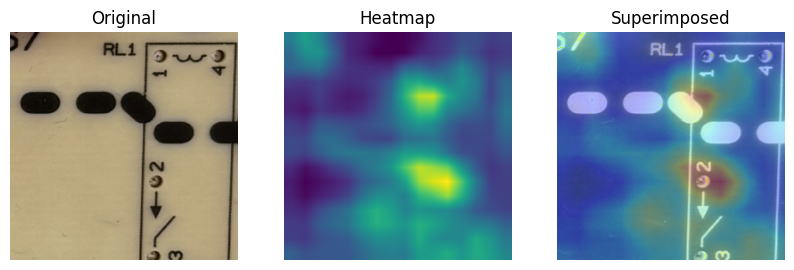

In [113]:
ix = 0

gradCAM = vision.GradCAM(vgg16_model, "block5_conv3")
class_id = np.argmax(vgg16_model.predict(np.expand_dims(defected[ix], axis=0))[0])

(heatmap, output) = gradCAM(np.expand_dims(defected[ix], axis=0), defected[ix]*255, class_id, alpha=0.4)

fig = plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(defected[ix])
plt.title("Original")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(heatmap)
plt.title("Heatmap")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(output)
plt.title("Superimposed")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 28ms/step


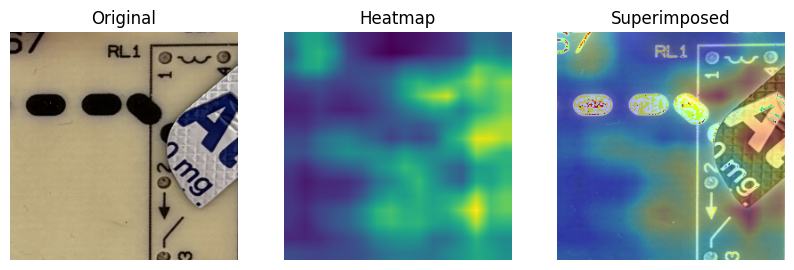

In [114]:
ix = 2

class_id_2 = np.argmax(vgg16_model.predict(np.expand_dims(defected[ix], axis=0))[0])

(heatmap2, output2) = gradCAM(np.expand_dims(defected[ix], axis=0), defected[ix]*255, class_id_2, alpha=0.4)

fig = plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(defected[ix])
plt.title("Original")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(heatmap2)
plt.title("Heatmap")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(output2)
plt.title("Superimposed")
plt.axis('off')
plt.show()

In [115]:
heatmap_diff = np.abs((heatmap / 255.0) - (heatmap2 / 255.0))

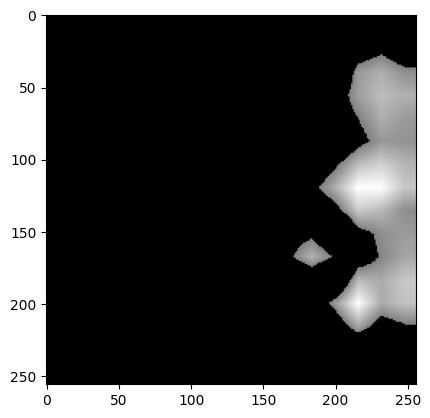

In [116]:
THRESHOLD = 0.5

heatmap_diff_show = heatmap_diff.copy()

numer = heatmap_diff_show - np.min(heatmap_diff_show)
denom = (heatmap_diff_show.max() - heatmap_diff_show.min()) + 1e-8
heatmap_diff_show = numer / denom

heatmap_diff_show[heatmap_diff_show < THRESHOLD] = 0.0
plt.imshow(heatmap_diff_show, cmap='gray')

In [112]:
from PIL import Image
im = Image.fromarray(defected[0])
im.save("asd_ref.png")
im.save("asd.png")

In [109]:
test_img_1 = utils.load_images("asd.png", scl=True)

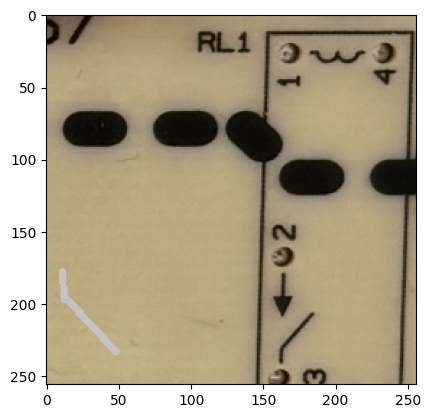

In [110]:
plt.imshow(test_img_1)

1/1 [==============================] - 0s 19ms/step


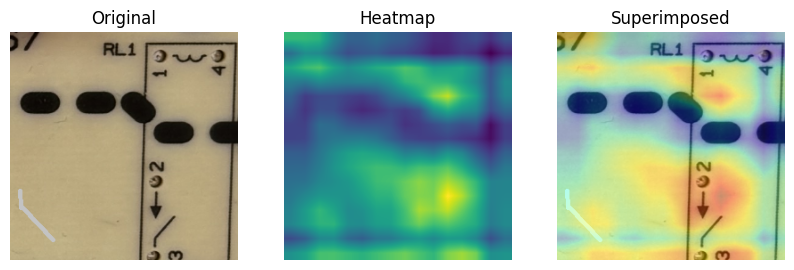

In [120]:
class_id_3 = np.argmax(vgg16_model.predict(np.expand_dims(test_img_1, axis=0))[0])

(heatmap3, output3) = gradCAM(np.expand_dims(test_img_1, axis=0), test_img_1*255, class_id_3, alpha=0.4)

fig = plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(test_img_1)
plt.title("Original")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(heatmap3)
plt.title("Heatmap")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(output3)
plt.title("Superimposed")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 34ms/step


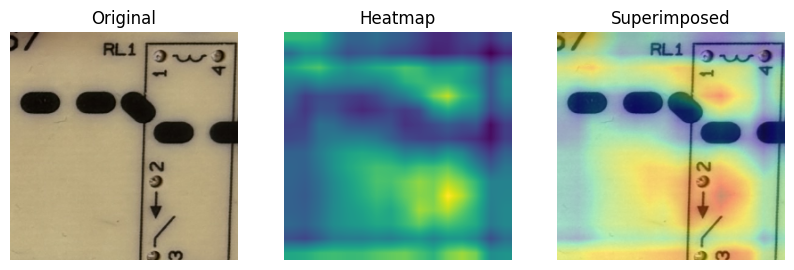

In [121]:
test_img_2 = utils.load_images("asd_ref.png", scl=True)

class_id_4 = np.argmax(vgg16_model.predict(np.expand_dims(test_img_2, axis=0))[0])

(heatmap4, output4) = gradCAM(np.expand_dims(test_img_2, axis=0), test_img_2*255, class_id_4, alpha=0.4)

fig = plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(test_img_2)
plt.title("Original")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(heatmap4)
plt.title("Heatmap")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(output4)
plt.title("Superimposed")
plt.axis('off')
plt.show()